In [5]:
from zipfile import ZipFile
file_name = '/content/PlantVillage2.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [19]:
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import time

from PIL import Image

import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models

## Load the data

Here I'll use `torchvision` to load the data.

The pre-trained networks I'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets I'll normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.


In [7]:
data_dir = '/content/PlantVillage2'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'

### Data augmentation and normalization

In [8]:
# DONE: Define your transforms for the training, validation, and testing sets
training_transforms = transforms.Compose([transforms.RandomRotation(30), transforms.RandomResizedCrop(
    224), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
validation_transforms = transforms.Compose([transforms.Resize(255), transforms.CenterCrop(
    224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
testing_transforms = validation_transforms

### Data Loading

In [9]:
# DONE: Load the datasets with ImageFolder
training_dataset = datasets.ImageFolder(
    train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(
    valid_dir, transform=validation_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

### Data batching

In [10]:
# DONE: Using the image datasets and the trainforms, define the dataloaders
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=64, shuffle=True)
testing_loader = torch.utils.data.DataLoader(
    testing_dataset, batch_size=64, shuffle=True)

### Preparing the pre-trained network - densenet121

I picked `densenet121` for this project because it can smoothly run on my local machine and it can produce great results.

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
device

device(type='cuda')

In [22]:
lr = 0.001
epochs = 5

In [14]:
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

# Freezing the parameteres
for param in model.parameters():
    param.requires_grad = False

# Default:
# (classifier): Linear(in_features=1024, out_features=1000, bias=True)

classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 512)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(p=0.3)),
    ('fc2', nn.Linear(512, 256)),
    ('relu2', nn.ReLU()),
    ('dropout2', nn.Dropout(p=0.3)),
    ('fc3', nn.Linear(256, len(training_dataset.class_to_idx))),
    ('output', nn.LogSoftmax(dim=1))
]))

model.classifier = classifier

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 66.5MB/s]


In [15]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=lr)

In [23]:
model.to(device)

steps = 0
print_every = 40

for epoch in range(epochs):
    running_loss = 0
    steps_no = len(training_loader)
    for step, (inputs, labels) in enumerate(training_loader):
        start_time = time.time()
        print(f'Step {step} of {steps_no}')
        images, labels = inputs.to(device), labels.to(
            device)  # Moving to GPU or CPU

        optimizer.zero_grad()  # Clearing the gradients

        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Run validation and testing then print the results

        if steps % print_every == 0:
            validation_loss = 0
            validation_accuracy = 0



            model.eval()
            with torch.no_grad():
                for images, labels in validation_loader:

                    images, labels = images.to(device), labels.to(
                        device)  # Moving to GPU or CPU

                    log_ps = model.forward(images)
                    loss = criterion(log_ps, labels)
                    validation_loss += loss.item()

                    ps = torch.exp(log_ps)
                    top_ps, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    validation_accuracy += torch.mean(
                        equals.type(torch.FloatTensor)).item()
            end_time = time.time()
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {validation_loss/len(validation_loader):.3f}.. "
                  f"Validation accuracy: {validation_accuracy/len(validation_loader)*100:.3f}%"
                  f"  ---  Time taken {end_time - start_time}"
                  )

            running_loss = 0

            model.train()

Step 0 of 170
Epoch 1/5.. Train loss: 0.021.. Validation loss: 0.671.. Validation accuracy: 76.690%  ---  Time taken 18.560829877853394
Step 1 of 170
Epoch 1/5.. Train loss: 0.026.. Validation loss: 0.581.. Validation accuracy: 80.963%  ---  Time taken 17.996445178985596
Step 2 of 170
Epoch 1/5.. Train loss: 0.021.. Validation loss: 0.534.. Validation accuracy: 83.546%  ---  Time taken 18.480886936187744
Step 3 of 170
Epoch 1/5.. Train loss: 0.023.. Validation loss: 0.562.. Validation accuracy: 81.314%  ---  Time taken 18.023204565048218
Step 4 of 170
Epoch 1/5.. Train loss: 0.022.. Validation loss: 0.614.. Validation accuracy: 78.444%  ---  Time taken 18.451380729675293
Step 5 of 170
Epoch 1/5.. Train loss: 0.028.. Validation loss: 0.647.. Validation accuracy: 76.467%  ---  Time taken 17.984909296035767
Step 6 of 170
Epoch 1/5.. Train loss: 0.022.. Validation loss: 0.660.. Validation accuracy: 76.531%  ---  Time taken 18.45892834663391
Step 7 of 170
Epoch 1/5.. Train loss: 0.024.. Val

KeyboardInterrupt: ignored

## Testing the network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images.

Testing accuracy on the test set with `dense121` is 84.005%

In [37]:
model.to(device)
model.eval()
with torch.no_grad():
    total = 0
    total_correct = 0

    for images, labels in testing_loader:

        images, labels = images.to(device), labels.to(
            device)  # Moving to GPU or CPU

        log_ps = model.forward(images)
        ps = torch.exp(log_ps)
        top_ps, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        total_correct += torch.sum(equals.type(torch.FloatTensor)).item()
        total += labels.size(0)

print(f"Accuracy on test images: {total_correct/total*100:.3f}%")

Accuracy on test images: 91.447%


## Saving the checkpoint

I might need to completely rebuild the model later, so I'm including all of the information I might need in the checkpoint.

In [24]:
model.to('cpu')

model.class_to_idx = training_dataset.class_to_idx  # type: ignore

arch = 'densenet121' if model._get_name() == 'DenseNet' else 'alexnet'

checkpoint = {'classifier': model.classifier,
              'arch':       arch,
              'epochs':     epochs,
              'lr': lr,
              'state_dict': model.state_dict(),
              'mapping':    model.class_to_idx
              }

torch.save(checkpoint, f'{arch}-checkpoint.pth')

## Loading the checkpoint

In [ ]:
def load_checkpoint(checkpoint):
    model_checkpoint = torch.load(checkpoint)

    model_arch = model_checkpoint['arch']
    if model_arch == 'alexnet':
        model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
    elif model_arch == 'densenet121':
        model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
    else:
        print('The model architecture is not supported, terminating the program..')
        exit(1)

    model.classifier = model_checkpoint['classifier']
    model.load_state_dict(model_checkpoint['state_dict'])
    model.class_to_idx = model_checkpoint['mapping']
    epochs = model_checkpoint['epochs']
    lr = model_checkpoint['lr']
    return model, epochs, lr

In [ ]:
# Testing the checkpoint method

model, epochs, lr = load_checkpoint('densenet121-checkpoint.pth')
model

# Inference for classification

Writing a function `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities.

Image processing must be handled first, then the image must be passed through the model to get the probabilities.

In [25]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    width, height = image.size

    if width < height:
        image = image.resize((256, 256*height//width))
    else:
        image = image.resize((256*width//height, 256))

    width, height = image.size
    reduce = 224
    left = (width - reduce)/2
    top = (height - reduce)/2
    right = left + 224
    bottom = top + 224
    im = image.crop((left, top, right, bottom))

    np_image = np.array(im)/255
    np_image -= np.array([0.485, 0.456, 0.406])
    np_image /= np.array([0.229, 0.224, 0.225])

    np_image = np_image.transpose((2, 0, 1))
    return np_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [26]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

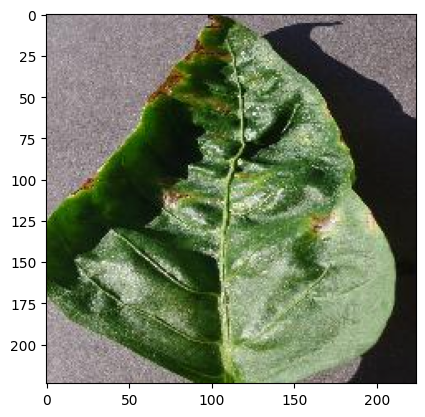

In [32]:
# Checking the image processing

image = Image.open('/content/PlantVillage2/test/Pepper__bell___Bacterial_spot/01940b6d-7dea-4889-a7b8-a35f4e9bba34___NREC_B.Spot 9120.JPG')
image = process_image(image)
imshow(torch.from_numpy(image))

plt.show()

## Class Prediction

Now that I have the images in the correct format, the `predict` function is ready to handle making predictions with the model.

In [33]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    image = Image.open(image_path)
    image = torch.from_numpy(process_image(image)).type(
        torch.FloatTensor)  # type: ignore

    model.eval()
    with torch.no_grad():
        model.to('cpu')
        # we're using unsqueeze to add a batch dimension so that it wpuld be compatible with the model
        log_ps = model.forward(image.unsqueeze(0))
    ps = torch.exp(log_ps)
    values, indices = ps.topk(topk)

    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    classes = [idx_to_class[idx] for idx in indices.numpy()[0].tolist()]

    return values, classes

## Sanity Checking

Now that we can use a trained model for predictions, I'm checking to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs.

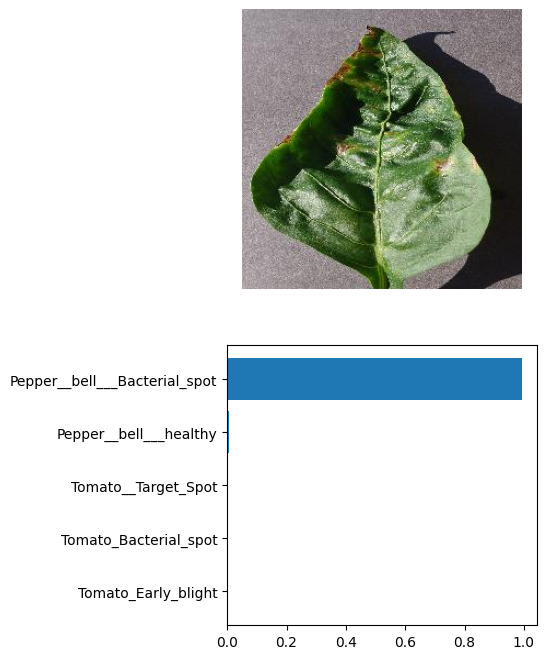

In [36]:
file_path = '/content/PlantVillage2/test/Pepper__bell___Bacterial_spot/01940b6d-7dea-4889-a7b8-a35f4e9bba34___NREC_B.Spot 9120.JPG'  # an example from test set

img_class = file_path.split('/')[2]

img = Image.open(file_path)
processed_image = process_image(img.copy())

probs, classes = predict(file_path, model, 5)
#classes = [cat_to_name[cls] for cls in classes]

fig, (ax0, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(4, 8))

ax0.imshow(img)
ax0.axis('off')
#ax0.set_title(cat_to_name[img_class])

ax1.barh(classes[::-1], probs.numpy()[0][::-1])

plt.show()